In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import plotly.io as pio
from plotly import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
import pandas as pd
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, normalize
import kaleido

load_dotenv()

import os,sys
sys.path.append(os.path.abspath(os.path.join('..')))

from scripts.utils import *
from DB_Connection.connection import ConnectionToPostgres

username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
name = os.getenv('DB_NAME')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

In [56]:
db = ConnectionToPostgres(dbname=name, user=username, password=password, host=host, port=port)
db.connect()

query = 'select * from xdr_data'
result = db.execute(query)

df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])#-
# df.head()

db.close_connection()

Connected to the PostgreSQL database
PostgreSQL connection is closed


In [57]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [58]:
df.tail()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0
150000,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,NaN,NaN


In [59]:
df.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

In [60]:
df.shape

(150001, 55)

In [61]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 55)


In [62]:
df.count()

Bearer Id                                   149010
Start                                       150000
Start ms                                    150000
End                                         150000
End ms                                      150000
Dur. (ms)                                   150000
IMSI                                        149431
MSISDN/Number                               148935
IMEI                                        149429
Last Location Name                          148848
Avg RTT DL (ms)                             122172
Avg RTT UL (ms)                             122189
Avg Bearer TP DL (kbps)                     150000
Avg Bearer TP UL (kbps)                     150000
TCP DL Retrans. Vol (Bytes)                  61855
TCP UL Retrans. Vol (Bytes)                  53352
DL TP < 50 Kbps (%)                         149247
50 Kbps < DL TP < 250 Kbps (%)              149247
250 Kbps < DL TP < 1 Mbps (%)               149247
DL TP > 1 Mbps (%)             

In [63]:
print(percentage_missing_values(df))

The telecom contains Bearer Id                                    0.66
Start                                        0.00
Start ms                                     0.00
End                                          0.00
End ms                                       0.00
Dur. (ms)                                    0.00
IMSI                                         0.38
MSISDN/Number                                0.71
IMEI                                         0.38
Last Location Name                           0.77
Avg RTT DL (ms)                             18.55
Avg RTT UL (ms)                             18.54
Avg Bearer TP DL (kbps)                      0.00
Avg Bearer TP UL (kbps)                      0.00
TCP DL Retrans. Vol (Bytes)                 58.76
TCP UL Retrans. Vol (Bytes)                 64.43
DL TP < 50 Kbps (%)                          0.50
50 Kbps < DL TP < 250 Kbps (%)               0.50
250 Kbps < DL TP < 1 Mbps (%)                0.50
DL TP > 1 Mbps (%)           

In [64]:
print(df.isnull().sum())

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

Droppping Some Columns

In [65]:
df = df.drop(columns=["Nb of sec with 125000B < Vol DL", "Nb of sec with 1250B < Vol UL < 6250B", "Nb of sec with 31250B < Vol DL < 125000B",
"Nb of sec with 37500B < Vol UL", "Nb of sec with 6250B < Vol UL < 37500B", "HTTP DL (Bytes)", "HTTP UL (Bytes)", "Avg RTT DL (ms)", "Avg RTT UL (ms)", "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)", "Nb of sec with 6250B < Vol DL < 31250B"])
df.head(10)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0
5,1.311448e+19,4/12/2019 21:37,439.0,4/25/2019 8:08,553.0,1074638.0,2.082014e+14,3.366819e+10,3.529841e+13,T89132C,...,21332918.0,2611113.0,7345361.0,6536448.0,710293538.0,13167974.0,654978277.0,4436057.0,30307754.0,754452212.0
6,1.311448e+19,4/13/2019 8:41,612.0,4/25/2019 8:16,168.0,1035261.0,2.082014e+14,3.366537e+10,8.676270e+13,9.16456701058919E+015,...,7234465.0,1886295.0,13231006.0,17981760.0,44796223.0,14084934.0,803653557.0,10649768.0,47925246.0,70562047.0
7,1.304243e+19,4/14/2019 2:11,592.0,4/25/2019 2:26,512.0,951292.0,2.082010e+14,3.376349e+10,8.654640e+13,CELL_208_20_520025_1,...,12189786.0,19735183.0,6858496.0,12075206.0,748906189.0,16149622.0,537601820.0,7714657.0,58813016.0,775350343.0
8,1.311448e+19,4/14/2019 12:48,121.0,4/25/2019 10:22,960.0,941634.0,2.082014e+14,3.369874e+10,3.556241e+13,T42084A,...,18436641.0,10860867.0,10587264.0,8467177.0,821671285.0,6548349.0,172920486.0,14749031.0,42363146.0,861612261.0
9,1.304243e+19,4/15/2019 0:32,0.0,4/25/2019 0:40,284.0,864482.0,2.082003e+14,3.365922e+10,3.557311e+13,L20434C,...,16338345.0,6573194.0,12211149.0,974201.0,811355188.0,1591237.0,64856042.0,12815208.0,22417975.0,850570347.0


In [66]:
df.count()

Bearer Id                         149010
Start                             150000
Start ms                          150000
End                               150000
End ms                            150000
Dur. (ms)                         150000
IMSI                              149431
MSISDN/Number                     148935
IMEI                              149429
Last Location Name                148848
Avg Bearer TP DL (kbps)           150000
Avg Bearer TP UL (kbps)           150000
DL TP < 50 Kbps (%)               149247
50 Kbps < DL TP < 250 Kbps (%)    149247
250 Kbps < DL TP < 1 Mbps (%)     149247
DL TP > 1 Mbps (%)                149247
UL TP < 10 Kbps (%)               149209
10 Kbps < UL TP < 50 Kbps (%)     149209
50 Kbps < UL TP < 300 Kbps (%)    149209
UL TP > 300 Kbps (%)              149209
Activity Duration DL (ms)         150000
Activity Duration UL (ms)         150000
Dur. (ms).1                       150000
Handset Manufacturer              149429
Handset Type    

sessions frequency

In [67]:
# Group users
users_data = df.groupby('MSISDN/Number')

# Get sessions frequency (count the number of sessions)
users_sessions= users_data['Bearer Id'].count()
users_sessions.head(10)

MSISDN/Number
3.360100e+10    1
3.360100e+10    1
3.360100e+10    1
3.360101e+10    1
3.360101e+10    2
3.360101e+10    2
3.360101e+10    2
3.360101e+10    1
3.360101e+10    2
3.360102e+10    1
Name: Bearer Id, dtype: int64

The duration of the session

In [68]:
# How long each session was
users_sessions= users_data['Dur. (ms)'].sum()
users_sessions

MSISDN/Number
3.360100e+10    116720.0
3.360100e+10    181230.0
3.360100e+10    134969.0
3.360101e+10     49878.0
3.360101e+10     37104.0
                  ...   
3.379000e+10      8810.0
3.379000e+10    140988.0
3.197021e+12    877385.0
3.370000e+14    253030.0
8.823971e+14    869844.0
Name: Dur. (ms), Length: 106856, dtype: float64

In [69]:
# Aggregation of Total values
df["Total Uploads"]=df["Google UL (Bytes)"]+df["Email UL (Bytes)"]+df["Social Media UL (Bytes)"]+df["Youtube UL (Bytes)"]+df["Netflix UL (Bytes)"]+df["Gaming UL (Bytes)"]+df["Other UL (Bytes)"]
df["Total Downloads"]=df["Google DL (Bytes)"]+df["Email DL (Bytes)"]+df["Social Media DL (Bytes)"]+df["Youtube DL (Bytes)"]+df["Netflix DL (Bytes)"]+df["Gaming DL (Bytes)"]+df["Other DL (Bytes)"]
df['Total UL and DL']=df['Total DL (Bytes)']+df["Total UL (Bytes)"]



# Aggregation of Total Social Media data
df["Youtube_Total_Data"]=df["Youtube DL (Bytes)"]+df["Youtube UL (Bytes)"]
df["Google_Total_Data"]=df["Google DL (Bytes)"]+df["Google UL (Bytes)"]
df["Email_Total_Data"]=df["Email DL (Bytes)"]+df["Email UL (Bytes)"]
df["Social_Media_Total_Data"]=df["Social Media DL (Bytes)"]+df["Social Media UL (Bytes)"]
df["Netflix_Total_Data"]=df["Netflix DL (Bytes)"]+df["Netflix UL (Bytes)"]
df["Gaming_Total_Data"]=df["Gaming DL (Bytes)"]+df["Gaming UL (Bytes)"]
df["Other_Total_Data"]=df["Other DL (Bytes)"]+df["Other UL (Bytes)"]

The sessions total traffic (download and upload (bytes))

In [70]:
users = df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms).1', 'Total UL and DL']].copy().rename(columns={'Dur. (ms).1': 'time_duration'})
users

,MSISDN/Number,Bearer Id,time_duration,Total UL and DL
0,3.366496e+10,1.311448e+19,1.823653e+09,345629377.0
1,3.368185e+10,1.311448e+19,1.365104e+09,707185356.0
2,3.376063e+10,1.311448e+19,1.361763e+09,307690973.0
3,3.375034e+10,1.311448e+19,1.321510e+09,889352748.0
4,3.369980e+10,1.311448e+19,1.089009e+09,607681403.0
...,...,...,...,...
149996,3.365069e+10,7.277826e+18,8.123076e+07,631804110.0
149997,3.366345e+10,7.349883e+18,9.797070e+07,705783925.0
149998,3.362189e+10,1.311448e+19,9.824953e+07,627698629.0
149999,3.361962e+10,1.311448e+19,9.791063e+07,401522016.0


In [71]:
users = users.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'time_duration': 'sum', 'Total UL and DL': 'sum'})
users = users.rename(columns={'Bearer Id': 'sessions'})
users.head(10)

,sessions,time_duration,Total UL and DL
MSISDN/Number,,,
3.360100e+10,1,116720140.0,8.786906e+08
3.360100e+10,1,181230963.0,1.568596e+08
3.360100e+10,1,134969374.0,5.959665e+08
3.360101e+10,1,49878024.0,4.223207e+08
3.360101e+10,2,37104453.0,1.457411e+09
3.360101e+10,2,253983077.0,6.152172e+08
3.360101e+10,2,128360523.0,6.547231e+08
3.360101e+10,1,86399977.0,3.326604e+08
3.360101e+10,2,495702147.0,9.901322e+08


### Task 2.1

Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric

Top 10 user Engagements to time

In [72]:
users.nlargest(10, 'time_duration')

,sessions,time_duration,Total UL and DL
MSISDN/Number,,,
3.362578e+10,17,1.855376e+10,8.499621e+09
3.361489e+10,17,9.966906e+09,8.846226e+09
3.376054e+10,15,9.279442e+09,8.514774e+09
3.362632e+10,18,8.791937e+09,7.971167e+09
3.366716e+10,13,8.744922e+09,5.618394e+09
3.366284e+10,9,6.614274e+09,4.000098e+09
3.366469e+10,9,6.288736e+09,5.682007e+09
3.360313e+10,12,6.287767e+09,4.976195e+09
3.366746e+10,6,5.649885e+09,2.600522e+09


In [73]:
import matplotlib.pyplot as plt

# Define the function to create multiple histograms
def mult_hist(data_list, rows, cols, title, labels):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, data in enumerate(data_list):
        ax = axes[i]
        ax.hist(data, bins=10, alpha=0.7, color='b', edgecolor='black')
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout so the title fits
    plt.show()

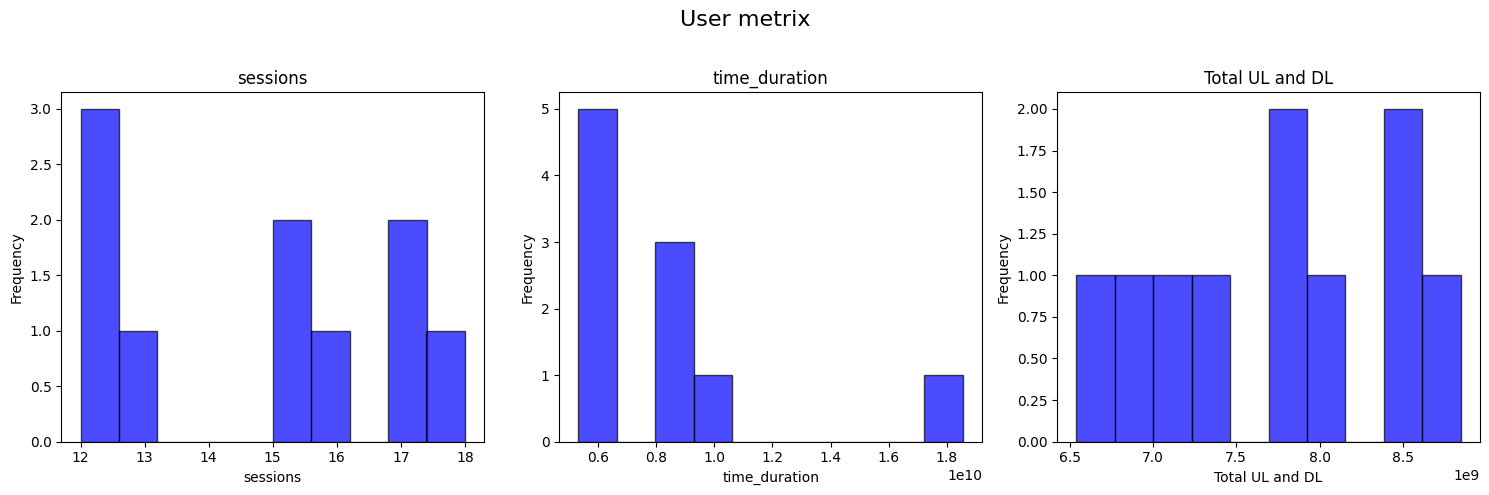

In [74]:
sessions = users.nlargest(10, "sessions")['sessions']
duration = users.nlargest(10, "time_duration")['time_duration']
data_volume = users.nlargest(10, "Total UL and DL")['Total UL and DL']

mult_hist([sessions, duration, data_volume], 1,3, "User metrix", ['sessions', 'time_duration','Total UL and DL'])